In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [3]:
labels = ['Abnormal(Ulcer)','Normal(Healthy skin)']

In [18]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFUEffectiveNet Dataset','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        try:
            img = cv2.resize(img,(image_size, image_size))
        except:
            break
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFUEffectiveNet Dataset','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 110/110 [00:01<00:00, 87.95it/s]


In [19]:
X_train.shape

(3190, 224, 224, 3)

In [20]:
X_train, y_train = shuffle(X_train,y_train, random_state=1010)

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=1010)

In [22]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [23]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

In [24]:
def inception_module(x, f1, f2, f3, f4):
		# 1x1 conv
		conv1 = keras.layers.Conv2D(f1, (1,1), strides=(1, 1), padding='same', activation='relu')(x)
		# 3x3 conv
		conv3 = keras.layers.Conv2D(f2, (3,3), strides=(1, 1), padding='same', activation='relu')(x)
		# 5x5 conv
		conv5 = keras.layers.Conv2D(f3, (5,5), strides=(1, 1), padding='same', activation='relu')(x)
		conv7 = keras.layers.Conv2D(f4, (7,7), strides=(1, 1), padding='same', activation='relu')(x)
		x = keras.layers.concatenate([conv1, conv3, conv5, conv7])
		return x

In [25]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

In [26]:
img_input = keras.Input(shape=(224, 224, 3))  #shape=(None, 299, 299, 3)
x = conv2d_bn(img_input, 64, 7, 7, strides=(2, 2), padding='same') # 149 x 149 x 32
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

x = conv2d_bn(x, 64, 1, 1, padding='same')  # 147 x 147 x 32
x = conv2d_bn(x, 192, 3, 3, padding='same') # 147 x 147 x 64
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

#inception_module(x, f1, f2, f3)
x = inception_module(x, 128, 128, 128, 128)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 192, 192, 192, 192)
x = inception_module(x, 256, 256, 256, 256)
x = inception_module(x, 256, 256, 256, 256)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 512, 512, 512, 512)
x = keras.layers.MaxPooling2D((7, 7), strides=(1, 1))(x)  # 35 x 35 x 192

#x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)
x = Flatten()(x)
x = keras.layers.Dense(1000, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='softmax', name='predictions')(x) #shape=(None, 1000) 

In [27]:
inputs = img_input
DFUV3 =  keras.Model(inputs, x, name='DFUEffectiveNetV3')
DFUV3.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("DFUV3.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
DFUV3.fit(X_train,y_train,validation_split=0.05, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
86/86 [==============================] - ETA: 0s - loss: 25.1164 - accuracy: 0.7044
Epoch 1: val_accuracy improved from -inf to 0.60417, saving model to DFUV3.h5
86/86 [==============================] - 49s 548ms/step - loss: 25.1164 - accuracy: 0.7044 - val_loss: 1.0367 - val_accuracy: 0.6042 - lr: 0.0010
Epoch 2/20
86/86 [==============================] - ETA: 0s - loss: 0.3961 - accuracy: 0.8309
Epoch 2: val_accuracy improved from 0.60417 to 0.90278, saving model to DFUV3.h5
86/86 [==============================] - 40s 467ms/step - loss: 0.3961 - accuracy: 0.8309 - val_loss: 0.3945 - val_accuracy: 0.9028 - lr: 0.0010
Epoch 3/20
86/86 [==============================] - ETA: 0s - loss: 0.2929 - accuracy: 0.8856
Epoch 3: val_accuracy did not improve from 0.90278
86/86 [==============================] - 36s 414ms/step - loss: 0.2929 - accuracy: 0.8856 - val_loss: 0.3715 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/20
86/86 [==============================] - ETA: 0s - loss: 0.2

In [28]:
def inception_module(x, f1, f2, f3, f4, f5):
		# 1x1 conv
		conv1 = keras.layers.Conv2D(f1, (1,1), strides=(1, 1), padding='same', activation='relu')(x)
		# 3x3 conv
		conv3 = keras.layers.Conv2D(f2, (3,3), strides=(1, 1), padding='same', activation='relu')(x)
		# 5x5 conv
		conv5 = keras.layers.Conv2D(f3, (5,5), strides=(1, 1), padding='same', activation='relu')(x)
		conv7 = keras.layers.Conv2D(f4, (7,7), strides=(1, 1), padding='same', activation='relu')(x)
		conv9 = keras.layers.Conv2D(f5, (9,9), strides=(1, 1), padding='same', activation='relu')(x)
		x = keras.layers.concatenate([conv1, conv3, conv5, conv7, conv9])
		return x

In [29]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

In [30]:
img_input = keras.Input(shape=(224, 224, 3))  #shape=(None, 299, 299, 3)

In [31]:
x = conv2d_bn(img_input, 64, 7, 7, strides=(2, 2), padding='same') # 149 x 149 x 32
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

x = conv2d_bn(x, 64, 1, 1, padding='same')  # 147 x 147 x 32
x = conv2d_bn(x, 192, 3, 3, padding='same') # 147 x 147 x 64
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

#inception_module(x, f1, f2, f3)
x = inception_module(x, 128, 128, 128, 128, 128)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 192, 192, 192, 192, 192)
x = inception_module(x, 256, 256, 256, 256, 256)
x = inception_module(x, 256, 256, 256, 256, 256)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 512, 512, 512, 512, 512)
x = keras.layers.MaxPooling2D((7, 7), strides=(1, 1))(x)  # 35 x 35 x 192

#x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)
x = Flatten()(x)
x = keras.layers.Dense(1000, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='softmax', name='predictions')(x) #shape=(None, 1000) 

In [32]:
inputs = img_input
DFUV4 =  keras.Model(inputs, x, name='DFUEffectiveNetV4')
DFUV4.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("DFUV4.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
DFUV4.fit(X_train,y_train,validation_split=0.05, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
86/86 [==============================] - ETA: 0s - loss: 162.8073 - accuracy: 0.7690
Epoch 1: val_accuracy improved from -inf to 0.65972, saving model to DFUV4.h5
86/86 [==============================] - 133s 1s/step - loss: 162.8073 - accuracy: 0.7690 - val_loss: 0.6011 - val_accuracy: 0.6597 - lr: 0.0010
Epoch 2/20
86/86 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.8651
Epoch 2: val_accuracy improved from 0.65972 to 0.90278, saving model to DFUV4.h5
86/86 [==============================] - 94s 1s/step - loss: 0.3196 - accuracy: 0.8651 - val_loss: 0.3578 - val_accuracy: 0.9028 - lr: 0.0010
Epoch 3/20
86/86 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.8805
Epoch 3: val_accuracy did not improve from 0.90278
86/86 [==============================] - 80s 936ms/step - loss: 0.2792 - accuracy: 0.8805 - val_loss: 0.2372 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 4/20
86/86 [==============================] - ETA: 0s - loss: 0.2472

In [33]:
def inception_module(x, f1, f2, f3):
		# 1x1 conv
		conv1 = keras.layers.Conv2D(f1, (1,1), strides=(1, 1), padding='same', activation='relu')(x)
		# 3x3 conv
		conv3 = keras.layers.Conv2D(f2, (3,3), strides=(1, 1), padding='same', activation='relu')(x)
		# 5x5 conv
		conv5 = keras.layers.Conv2D(f3, (5,5), strides=(1, 1), padding='same', activation='relu')(x)
		x = keras.layers.concatenate([conv1, conv3, conv5])
		return x

In [34]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

In [35]:
img_input = keras.Input(shape=(224, 224, 3))  
x = conv2d_bn(img_input, 64, 7, 7, strides=(2, 2), padding='same') # 149 x 149 x 32
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

x = conv2d_bn(x, 64, 1, 1, padding='same')  # 147 x 147 x 32
x = conv2d_bn(x, 192, 3, 3, padding='same') # 147 x 147 x 64
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

#inception_module(x, f1, f2, f3)
x = inception_module(x, 128, 128, 128)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 192, 192, 192)
x = inception_module(x, 256, 256, 256)
x = inception_module(x, 256, 256, 256)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 512, 512, 512)
x = keras.layers.MaxPooling2D((7, 7), strides=(1, 1))(x)  # 35 x 35 x 192

#x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)
x = Flatten()(x)
x = keras.layers.Dense(1000, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='softmax', name='predictions')(x) #shape=(None, 1000) 

In [36]:
inputs = img_input
DFUV2 =  keras.Model(inputs, x, name='DFUEffectiveNetV2')
DFUV2.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("DFUV2.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
DFUV2.fit(X_train,y_train,validation_split=0.05, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
86/86 [==============================] - ETA: 0s - loss: 4.7959 - accuracy: 0.6993
Epoch 1: val_accuracy improved from -inf to 0.61806, saving model to DFUV2.h5
86/86 [==============================] - 21s 199ms/step - loss: 4.7959 - accuracy: 0.6993 - val_loss: 0.7472 - val_accuracy: 0.6181 - lr: 0.0010
Epoch 2/20
86/86 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.8489
Epoch 2: val_accuracy improved from 0.61806 to 0.63194, saving model to DFUV2.h5
86/86 [==============================] - 15s 171ms/step - loss: 0.3702 - accuracy: 0.8489 - val_loss: 0.6558 - val_accuracy: 0.6319 - lr: 0.0010
Epoch 3/20
86/86 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.8922
Epoch 3: val_accuracy improved from 0.63194 to 0.88889, saving model to DFUV2.h5
86/86 [==============================] - 15s 173ms/step - loss: 0.2670 - accuracy: 0.8922 - val_loss: 0.2631 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 4/20
86/86 [=========================

In [37]:
def inception_module(x, f1, f2):
		# 1x1 conv
		conv1 = keras.layers.Conv2D(f1, (1,1), strides=(1, 1), padding='same', activation='relu')(x)
		# 3x3 conv
		conv3 = keras.layers.Conv2D(f2, (3,3), strides=(1, 1), padding='same', activation='relu')(x)
		x = keras.layers.concatenate([conv1, conv3])
		return x

In [38]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

In [39]:
img_input = keras.Input(shape=(224, 224, 3))  
x = conv2d_bn(img_input, 64, 7, 7, strides=(2, 2), padding='same') # 149 x 149 x 32
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

x = conv2d_bn(x, 64, 1, 1, padding='same')  # 147 x 147 x 32
x = conv2d_bn(x, 192, 3, 3, padding='same') # 147 x 147 x 64
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

#inception_module(x, f1, f2, f3)
x = inception_module(x, 128, 128)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 192, 192)
x = inception_module(x, 256, 256)
x = inception_module(x, 256, 256)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 512, 512)
x = keras.layers.MaxPooling2D((7, 7), strides=(1, 1))(x)  # 35 x 35 x 192

#x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)
x = Flatten()(x)
x = keras.layers.Dense(1000, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='softmax', name='predictions')(x) #shape=(None, 1000) 

In [40]:
inputs = img_input
DFUV1 =  keras.Model(inputs, x, name='DFUEffectiveNetV1')
DFUV1.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("DFUV1.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
DFUV1.fit(X_train,y_train,validation_split=0.05, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
86/86 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.7275
Epoch 1: val_accuracy improved from -inf to 0.59722, saving model to DFUV1.h5
86/86 [==============================] - 10s 93ms/step - loss: 0.6624 - accuracy: 0.7275 - val_loss: 2.4332 - val_accuracy: 0.5972 - lr: 0.0010
Epoch 2/20
85/86 [============================>.] - ETA: 0s - loss: 0.3548 - accuracy: 0.8559
Epoch 2: val_accuracy did not improve from 0.59722
86/86 [==============================] - 7s 76ms/step - loss: 0.3543 - accuracy: 0.8559 - val_loss: 0.7813 - val_accuracy: 0.5972 - lr: 0.0010
Epoch 3/20
85/86 [============================>.] - ETA: 0s - loss: 0.2673 - accuracy: 0.8963
Epoch 3: val_accuracy improved from 0.59722 to 0.65278, saving model to DFUV1.h5
86/86 [==============================] - 7s 80ms/step - loss: 0.2683 - accuracy: 0.8959 - val_loss: 0.5321 - val_accuracy: 0.6528 - lr: 0.0010
Epoch 4/20
85/86 [============================>.] - ETA: 0s - loss: 0.2576 - a

In [41]:
# predict probabilities
pred_prob1 = DFUV1.predict(X_test)
pred_prob2 = DFUV2.predict(X_test)
pred_prob3 = DFUV3.predict(X_test)
pred_prob4 = DFUV4.predict(X_test)

10/10 [==============================] - 8s 886ms/step


In [42]:
y_test=np.argmax(y_test,axis=1)

In [43]:
from sklearn.metrics import roc_curve
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [44]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score_DFUV1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score_DFUV2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score_DFUV3 = roc_auc_score(y_test, pred_prob3[:,1])
auc_score_DFUV4 = roc_auc_score(y_test, pred_prob4[:,1])

print(auc_score_DFUV1, auc_score_DFUV2, auc_score_DFUV3, auc_score_DFUV4)

0.9858974358974358 0.9822167080231596 0.9844086021505376 0.9856492969396194


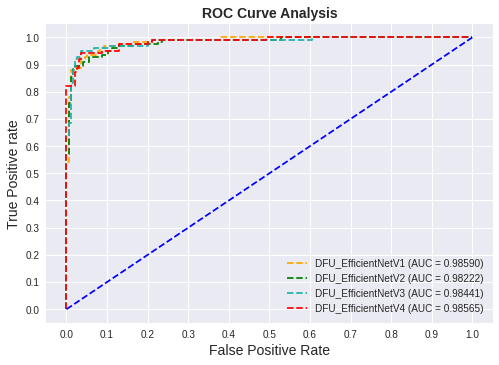

In [46]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='DFU_EfficientNetV1 (AUC = 0.98590)')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='DFU_EfficientNetV2 (AUC = 0.98222)')
plt.plot(fpr3, tpr3, linestyle='--',color='LightSeaGreen', label='DFU_EfficientNetV3 (AUC = 0.98441)')
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='DFU_EfficientNetV4 (AUC = 0.98565)')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=14)
plt.legend(prop={'size':14}, loc='lower right')
# x label
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel('False Positive Rate', fontsize=14)
# y label
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel('True Positive rate', fontsize=14)

plt.legend(loc='best')
plt.savefig('ROC curve1',dpi=400)
plt.show();